In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul                           #
# Date: November 2020                                               #
# If you use this code or the results from this work please cite:   # 
# Resurrecting bbh with kinematic shapes                            #
# Christophe Grojean, Ayan Paul and Zuoni Qian                      #
# arXiv:2011.13945 (https://arxiv.org/abs/2011.13945)               # 
#####################################################################

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import corner as crn
import math
import arviz as az
import os
import theano.tensor as tensor
import pandas as pd
from matplotlib import rc
from scipy import optimize
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'

In [2]:
def kappag_re_re(kbre):
    return -0.05*kbre + 1.05

def kappag_re_im(kbre):
    return 0.08*kbre + -0.08

def kappag_im_re(kbim):
    return -0.06*kbim

def kappag_im_im(kbim):
    return 0.08*kbim

def kappagam_re_re(kbre):
    return 0.004*kbre + 0.996

def kappagam_re_im(kbre):
    return -0.005*kbre + 0.005

def kappagam_im_re(kbim):
    return 0.004*kbim

def kappagam_im_im(kbim):
    return -0.005*kbim

def sigmabbh100(kbre, kbim):
    intr = -0.062237886957151184*kbim**2 + 1.0536810705678374*kbre - 0.053681070567837455*kbre**2
    return 32074.*(kbre**2 + kbim**2) - 964.*intr + 48772. + 1860. + 172088.

def sigmabbh200(kbre, kbim):
    intr = -0.062237886957151184*kbim**2 + 1.0536810705678374*kbre - 0.053681070567837455*kbre**2
    return 15112.*(kbre**2 + kbim**2) - 6815.*intr + 45751. + 4498. + 373436.

def sigmabbh1(kbre, kbim):
    intr = -0.062237886957151184*kbim**2 + 1.0536810705678374*kbre - 0.053681070567837455*kbre**2
    return (170.*(kbre**2 + kbim**2) - 7.*intr + 238. + 22. + 2183.)

def sigmabbh2(kbre, kbim):
    intr = -0.062237886957151184*kbim**2 + 1.0536810705678374*kbre - 0.053681070567837455*kbre**2
    return (54.*(kbre**2 + kbim**2) - 24.*intr + 112. + 28. + 2450.)

def likelihood1(x, y):
    # Likelihood for HL-LHC
    z_lim = 0.016
    z1_lim = 0.026
    z2_lim = 0.044
    z3_lim = sigmabbh1(1., 0.)
    z4_lim = sigmabbh2(1., 0.)
    
    return -((kappag_re_re(x)**2 + kappag_re_im(x)**2 + kappag_im_re(y)**2 + kappag_im_im(y)**2 - 1.)**2/z_lim**2 
             + (kappagam_re_re(x)**2 + kappagam_re_im(x)**2 + kappagam_im_re(y)**2 + kappagam_im_im(y)**2 - 1.)**2/z1_lim**2 
             + (x**2 + y**2 - 1.)**2/z2_lim**2 
             + (sigmabbh1(x, y) - z3_lim)**2/z3_lim 
             + (sigmabbh2(x, y) - z4_lim)**2/z4_lim) * 0.5

def likelihood2(x, y):
    # Likelihood for FCC-hh
    z_lim = 0.0098
    z1_lim = 0.0058
    z2_lim = 0.0086
    z3_lim = sigmabbh100(1., 0.)
    z4_lim = sigmabbh200(1., 0.)
    
    return -((kappag_re_re(x)**2 + kappag_re_im(x)**2 + kappag_im_re(y)**2 + kappag_im_im(y)**2 - 1.)**2/z_lim**2 
             + (kappagam_re_re(x)**2 + kappagam_re_im(x)**2 + kappagam_im_re(y)**2 + kappagam_im_im(y)**2 - 1.)**2/z1_lim**2 
             + (x**2 + y**2 - 1.)**2/z2_lim**2 
             + (sigmabbh100(x, y) - z3_lim)**2/z3_lim 
             + (sigmabbh200(x, y) - z4_lim)**2/z4_lim) * 0.5

def likelihood3(x, y):
    # Likelihood for HL-LHC without bbh
    z_lim = 0.016
    z1_lim = 0.026
    z2_lim = 0.044
    
    return -((kappag_re_re(x)**2 + kappag_re_im(x)**2 + kappag_im_re(y)**2 + kappag_im_im(y)**2 - 1.)**2/z_lim**2 
             + (kappagam_re_re(x)**2 + kappagam_re_im(x)**2 + kappagam_im_re(y)**2 + kappagam_im_im(y)**2 - 1.)**2/z1_lim**2 
             + (x**2 + y**2 - 1.)**2/z2_lim**2) * 0.5

def likelihood4(x, y):
    # Likelihood for FCC-hh without bbh
    z_lim = 0.0098
    z1_lim = 0.0058
    z2_lim = 0.0086
    
    return -((kappag_re_re(x)**2 + kappag_re_im(x)**2 + kappag_im_re(y)**2 + kappag_im_im(y)**2 - 1.)**2/z_lim**2 
             + (kappagam_re_re(x)**2 + kappagam_re_im(x)**2 + kappagam_im_re(y)**2 + kappagam_im_im(y)**2 - 1.)**2/z1_lim**2 
             + (x**2 + y**2 - 1.)**2/z2_lim**2) * 0.5

def runMCMC(likelihood, limits, trace_dir='', config=[], fit=True):
    """ pyMC3 MCMC run
        argument:
            likelihood: the likelihood function
            limits: an array of the limits for the parameters [r_lowers, r_upper, theta_lower, theta_upper]
            trace_dir: the directory to which the MCMC traces are saves. '' implies none
            config: the setup for the MCMC. [MCMC smaple size, target_accept, chains]
            fit: bolean for determining whether to run the fit
        returns:
            trace: if fit is true it returns the trace
            model;if fit is false it returns the model
    """
    with pm.Model() as model:
        r = pm.Uniform('r',lower=limits[0], upper=limits[1])
        theta = pm.Uniform('theta', lower=limits[2], upper=limits[3])

        x = r * tensor.cos(theta*math.pi/180.)
        y = r * tensor.sin(theta*math.pi/180.)

        like = pm.Potential('like', likelihood(x, y))
        
    if fit:
        with model:
            trace = pm.sample(config[0], tune=int(np.max([1000,config[0]/5])), cores=4, target_accept=config[1], chains=config[2], init='advi_map')
#             print(az.summary(trace, round_to=5)) Turn on to print summary
            if trace_dir != '': pm.save_trace(trace=trace, directory=trace_dir, overwrite=True)
        return trace, model
    return model

def makeCorner(trace, model, filename, collider):
    """ Corner plot builder
    argument:
        trace: the trace from the pyMC3 run
        filename: the file to save the plot in
        collider: a string with the collider name to attach to the plot
    """
    samples = np.vstack((trace['r'], trace['theta'])).T
    fig = plt.figure(figsize=(8,8))
    fig = crn.corner(samples,labels = [r"$|\kappa_b|$", r"$\phi_b$"], 
                     truths = None,bins=100,
                     show_titles=True, title_kwargs={"fontsize": 22}, label_kwargs={"fontsize": 22},
                     levels=(1.-np.exp(-0.5),1.-np.exp(-2.),1.-np.exp(-4.5)), 
                     plot_contours = True, fill_contours=True, smooth=True, smooth1d=True,
                     plot_datapoints = False, color='#3f7f93', labelpad=-0.15, fig=fig, title_fmt='.3f', hist_kwargs={'linewidth': 2}, 
                     range=[(0.9,1.1), (-80, 80)], truth_color='#343434')
    
    with model:
        df = pd.DataFrame(az.summary(trace, kind='stats', hdi_prob=0.6827))

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=22, rotation=0)
    
    ax = fig.get_axes()
    ## 1D histogram labels
    ax[0].axvspan(df.loc['r']['hdi_15.865%'], df.loc['r']['hdi_84.135%'], color='#3f7f93', zorder=1, linewidth=1.5, linestyle='-', alpha=0.25)
    ax[0].set_title(r'$|\kappa_b| = [{:.3f}, {:.3f}]$'.format(df.loc['r']['hdi_15.865%'], df.loc['r']['hdi_84.135%']), fontsize=22)
    
    ax[3].axvspan(df.loc['theta']['hdi_15.865%'], df.loc['theta']['hdi_84.135%'], color='#3f7f93', zorder=1, linewidth=1.5, linestyle='-', alpha=0.25)
    ax[3].set_title(r'$\phi_b = [{:.1f}^\circ, {:.1f}^\circ]$'.format(df.loc['theta']['hdi_15.865%'], df.loc['theta']['hdi_84.135%']), fontsize=22)
    
    ## title
    ax[1].annotate(collider, xy=(0.5, 0.7), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=28, fontweight='bold')
    ax[1].annotate('Best Fit Point:', xy=(0.5, 0.6), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)
    ax[1].annotate(r'$|\kappa_b| = 1.0$', xy=(0.5, 0.5), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)
    ax[1].annotate(r'$\phi_b = 0.0^\circ$', xy=(0.535, 0.4), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='center', fontsize=22)
    
    ## grid
    ax[2].grid(linestyle=':', zorder=0)
    
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
def mode(x):
    # Function to find mode of an array x
    n, bins = np.histogram(x, bins=101)
    m = np.argmax(n)
    m = (bins[m] + bins[m-1])/2.
    return m

def minimize(likelihood, guess):
    """ Minimizing routine for finding global mode
    argument:
        likelihood: the likelihood function
        guess: the guess for the mode, [r, theta]
    """
    res = optimize.minimize(lambda x: -likelihood(x[0], x[1]), guess, method='BFGS', tol=1e-6)
    return res

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 9900
Interrupted at 9,899 [4%]: Average Loss = 13.379
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [theta, r]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 1236 seconds.


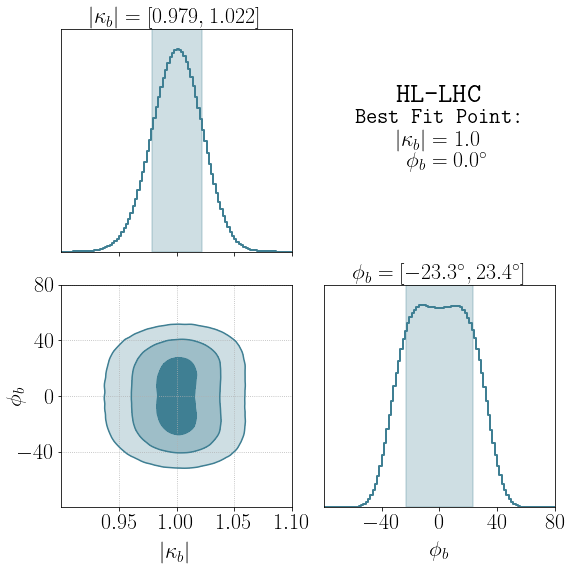

In [3]:
## HL-LHC
# trace_dir = 'traces/traces-HL-LHC-2P' ## Specify to save the trace
limits = [0.5, 1.5, -180., 180.]
config = [150000, 0.8, 50]
trace_HL_LHC, model_HL_LHC = runMCMC(likelihood1, limits, config=config)
filename = '../plots/kappa_b-2P-HL-LHC.pdf'
makeCorner(trace_HL_LHC, model_HL_LHC, filename, collider='HL-LHC')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 7100
Interrupted at 7,099 [3%]: Average Loss = 5.4342
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [theta, r]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 1209 seconds.


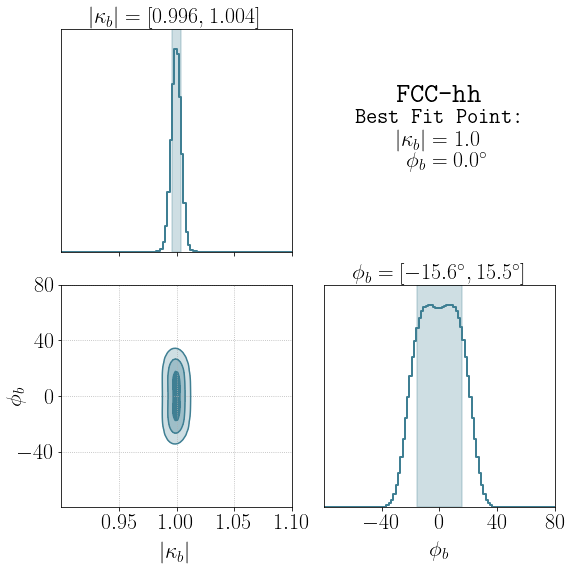

In [4]:
## FCC-hh
# trace_dir = 'traces/traces-FCC-2P' ## Specify to save the trace
limits = [0.95, 1.05, -45., 45.]
config = [150000, 0.8, 50]
trace_FCC, model_FCC = runMCMC(likelihood2, limits, config=config)
filename = '../plots/kappa_b-2P-FCC.pdf'
makeCorner(trace_FCC, model_FCC, filename, collider='FCC-hh')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 9800
Interrupted at 9,799 [4%]: Average Loss = 13.357
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [theta, r]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 1197 seconds.


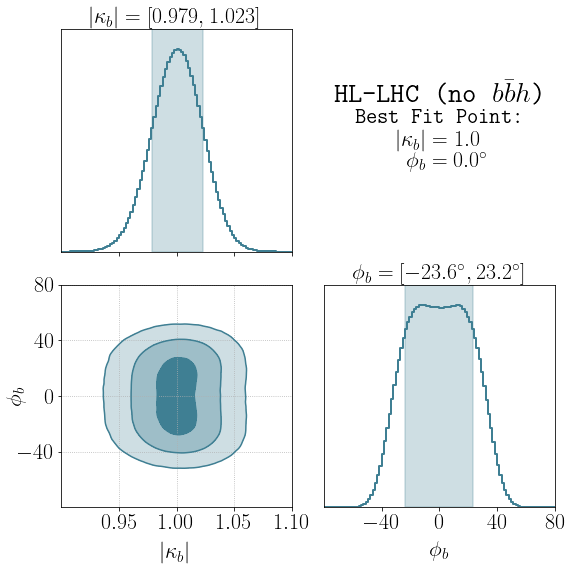

In [5]:
## HL-LHC no bbh
# trace_dir = 'traces/traces-HL-LHC-2PO' ## Specify to save the trace
limits = [0.5, 1.5, -180., 180.]
config = [150000, 0.8, 50]
trace_HL_LHC, model_HL_LHC = runMCMC(likelihood3, limits, config=config)
filename = '../plots/kappa_b-2PO-HL-LHC.pdf'
makeCorner(trace_HL_LHC, model_HL_LHC, filename, collider=r'HL-LHC (no $b\bar{b}h$)')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Convergence achieved at 7000
Interrupted at 6,999 [3%]: Average Loss = 4.5334
Multiprocess sampling (50 chains in 4 jobs)
NUTS: [theta, r]


Sampling 50 chains for 30_000 tune and 150_000 draw iterations (1_500_000 + 7_500_000 draws total) took 1140 seconds.


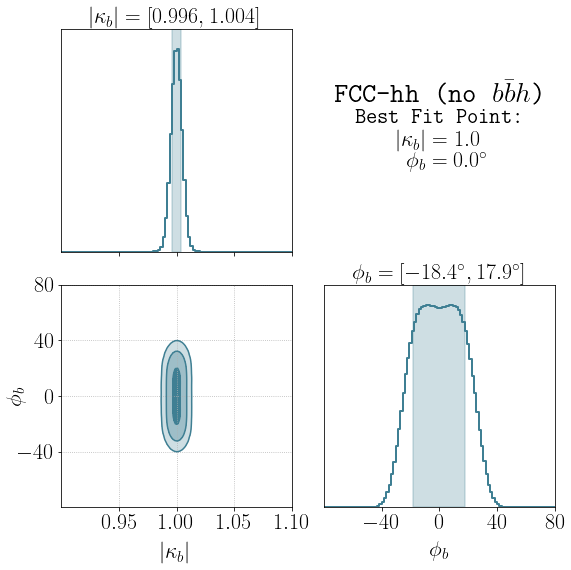

In [6]:
## FCC-hh no bbh
# trace_dir = 'traces/traces-FCC-2PO' ## Specify to save the trace
limits = [0.95, 1.05, -45., 45.]
config = [150000, 0.8, 50]
trace_FCC, model_FCC = runMCMC(likelihood4, limits, config=config)
filename = '../plots/kappa_b-2PO-FCC.pdf'
makeCorner(trace_FCC, model_FCC, filename, collider=r'FCC-hh (no $b\bar{b}h$)')